# Project: **Finding Lane Lines on the Road** 

In this notebook, the pipline for identifying simple lane lines is implemented and applied to a sample video.

## 0. Imports

In [1]:
import os
import math
import numpy as np
import scipy as sp
import scipy.optimize as spo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2


plt.rcParams["figure.figsize"] = [40, 40]

## 1. Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


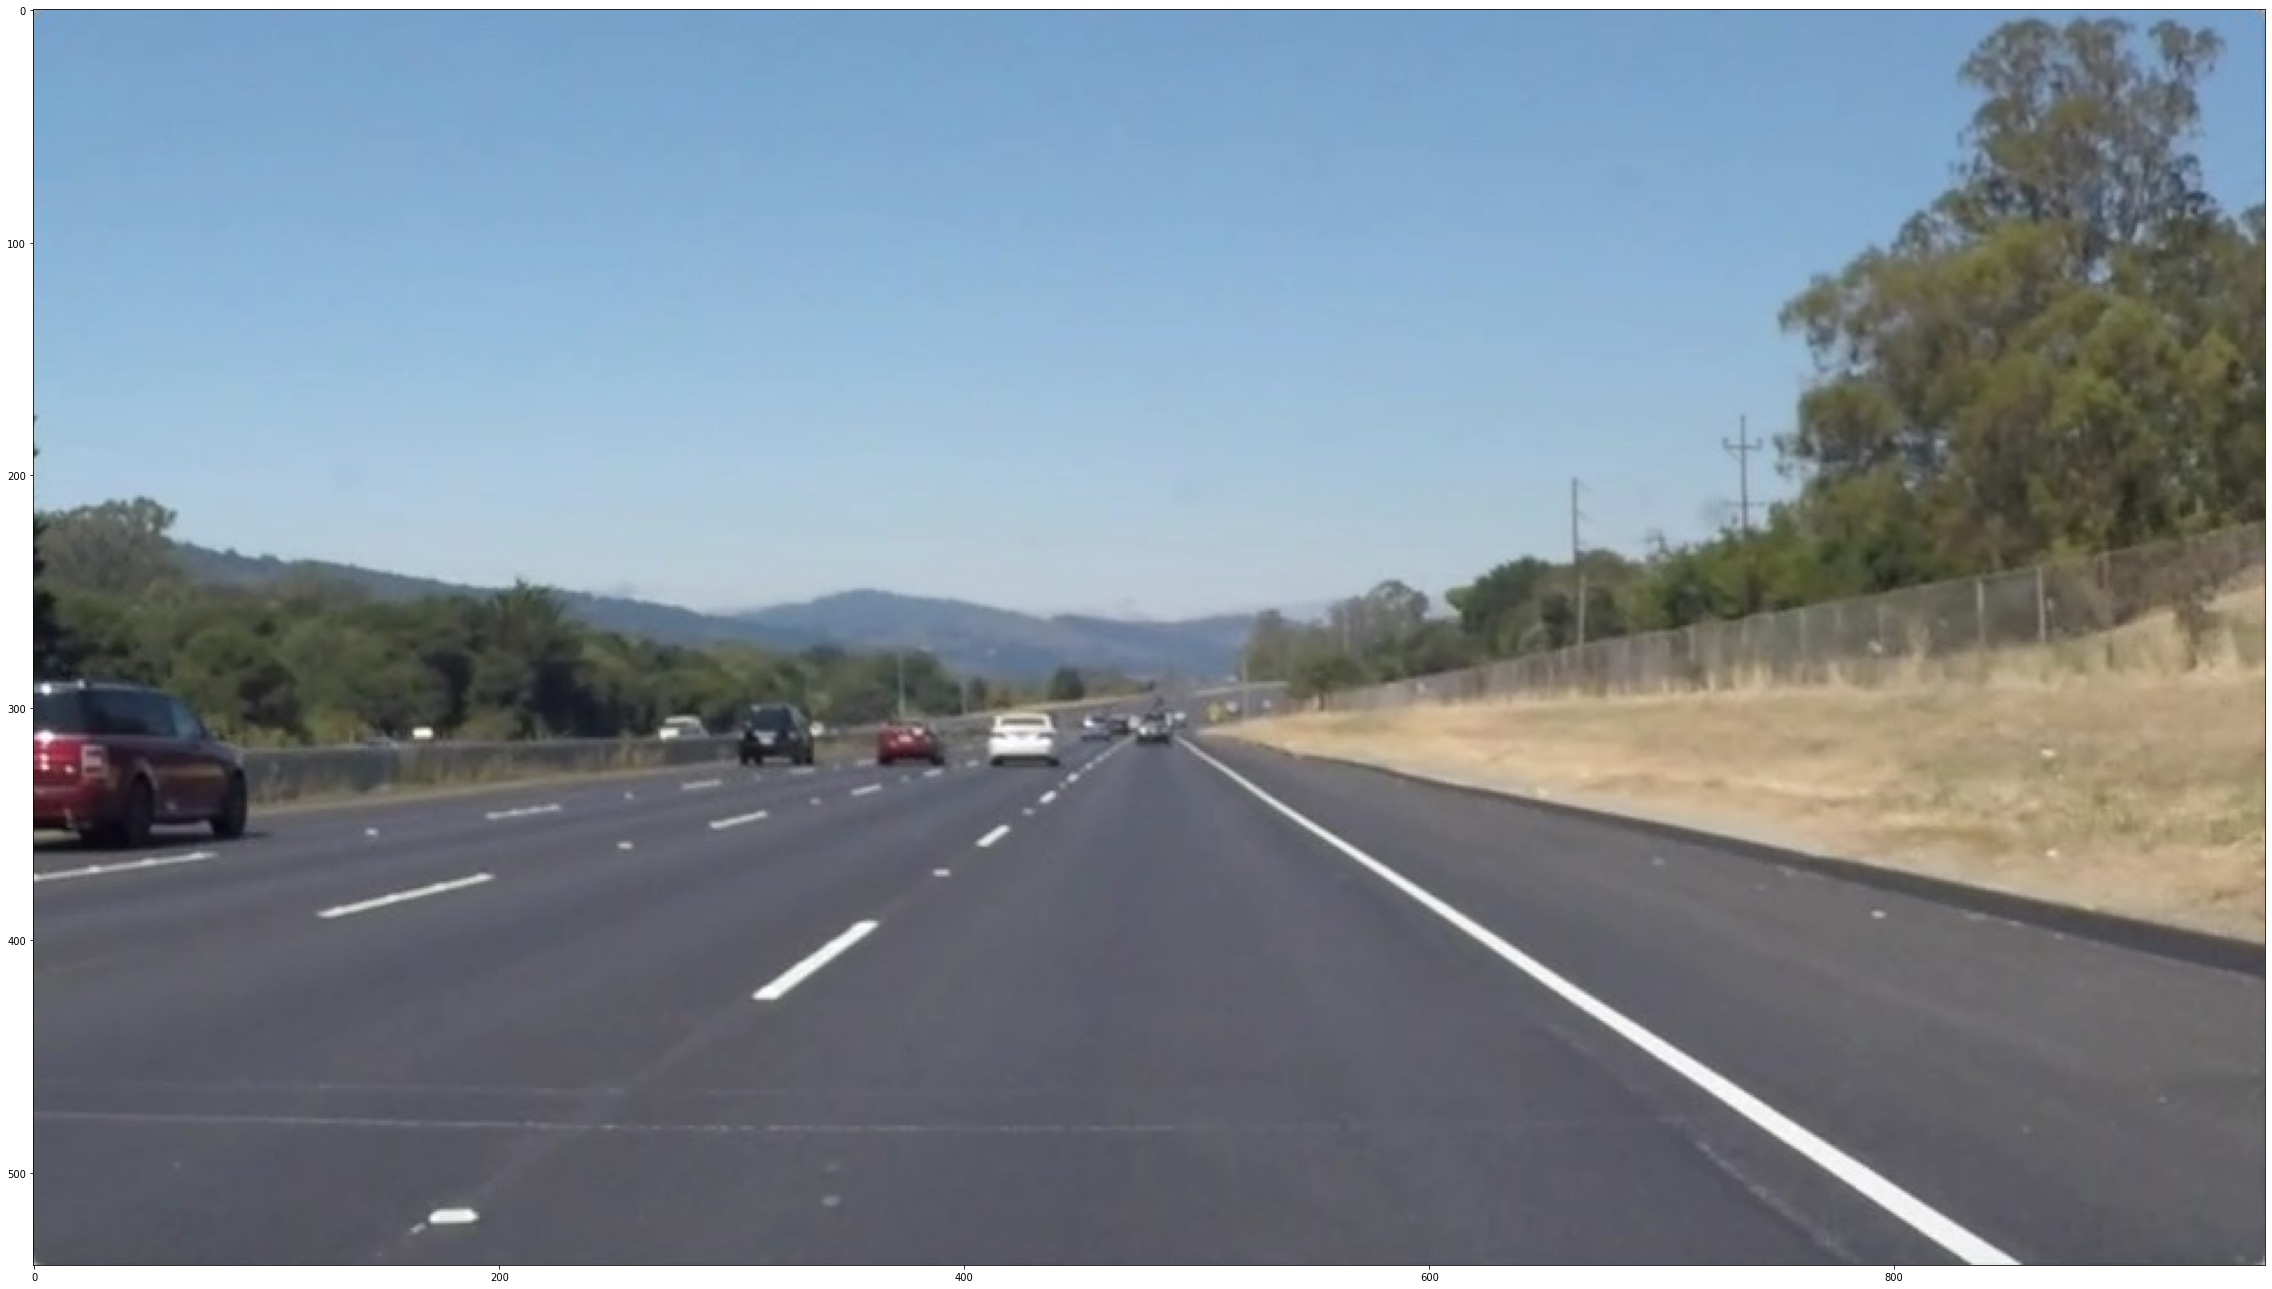

In [2]:
# Reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')


# Printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## 2. Test Images

These are some test images we will use to test the pipeline.

In [3]:
images = os.listdir("test_images/")
print(images)

['solidWhiteCurve.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg']


## 3. Pipleline and Parameters Tuning


In [4]:
class Parameters:
    def __init__(self, imshape):
        self.gaussian_keral_size = 5             # Kernal size for the smoothing
        self.canny_low_threshold = 50            # Canny transform low threshhold
        self.canny_high_threshold = 150          # Canny transform high threshhold
        self.vertices = np.array([[(0, imshape[0]), (430, 330), (520, 330), (imshape[1], imshape[0])]], dtype=np.int32) # Vertices of 2D polygon mask
        self.hough_rho = 1                       # Distance resolution in pixels of the Hough grid  
        self.hough_theta = np.pi / 180           # Agular resolution in radians of the Hough grid
        self.hough_threshold = 1                 # Minimum number of votes (intersections in Hough grid cell)
        self.hough_min_line_length = 50          # Minimum number of pixels making up a line
        self.hough_max_line_gap = 30             # Maximum gap in pixels between connectable line segments

        
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2, vertices=None):  # Added vertices parameter, this will be used in the improved draw_lines. Set to None here to make function calles consistent.
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices=None):  # Added vertices parameter, this will be used in the improved draw_lines. Set to None here to make function calles consistent.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices=vertices)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ) 


def draw_lanes(image, parameters=None):
    # Use default prameters if none given
    if parameters is None:
        parameters = Parameters(image.shape)
    
    # Convert to grayscale
    gray = grayscale(image)

    # Remove noise using Gaussian smoothing
    blur_gray = gaussian_blur(gray, parameters.gaussian_keral_size)

    # Apply Canny edge detection
    edges = canny(blur_gray, parameters.canny_low_threshold, parameters.canny_high_threshold)

    # Create a masked edges image
    masked_edges = region_of_interest(edges, parameters.vertices)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, parameters.hough_rho, parameters.hough_theta, parameters.hough_threshold, parameters.hough_min_line_length, parameters.hough_max_line_gap, vertices=parameters.vertices)

    # Draw the lines on the edge image
    lines_edges = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    # Return tuple of result images
    return (image, gray, blur_gray, edges, masked_edges, lines_edges)

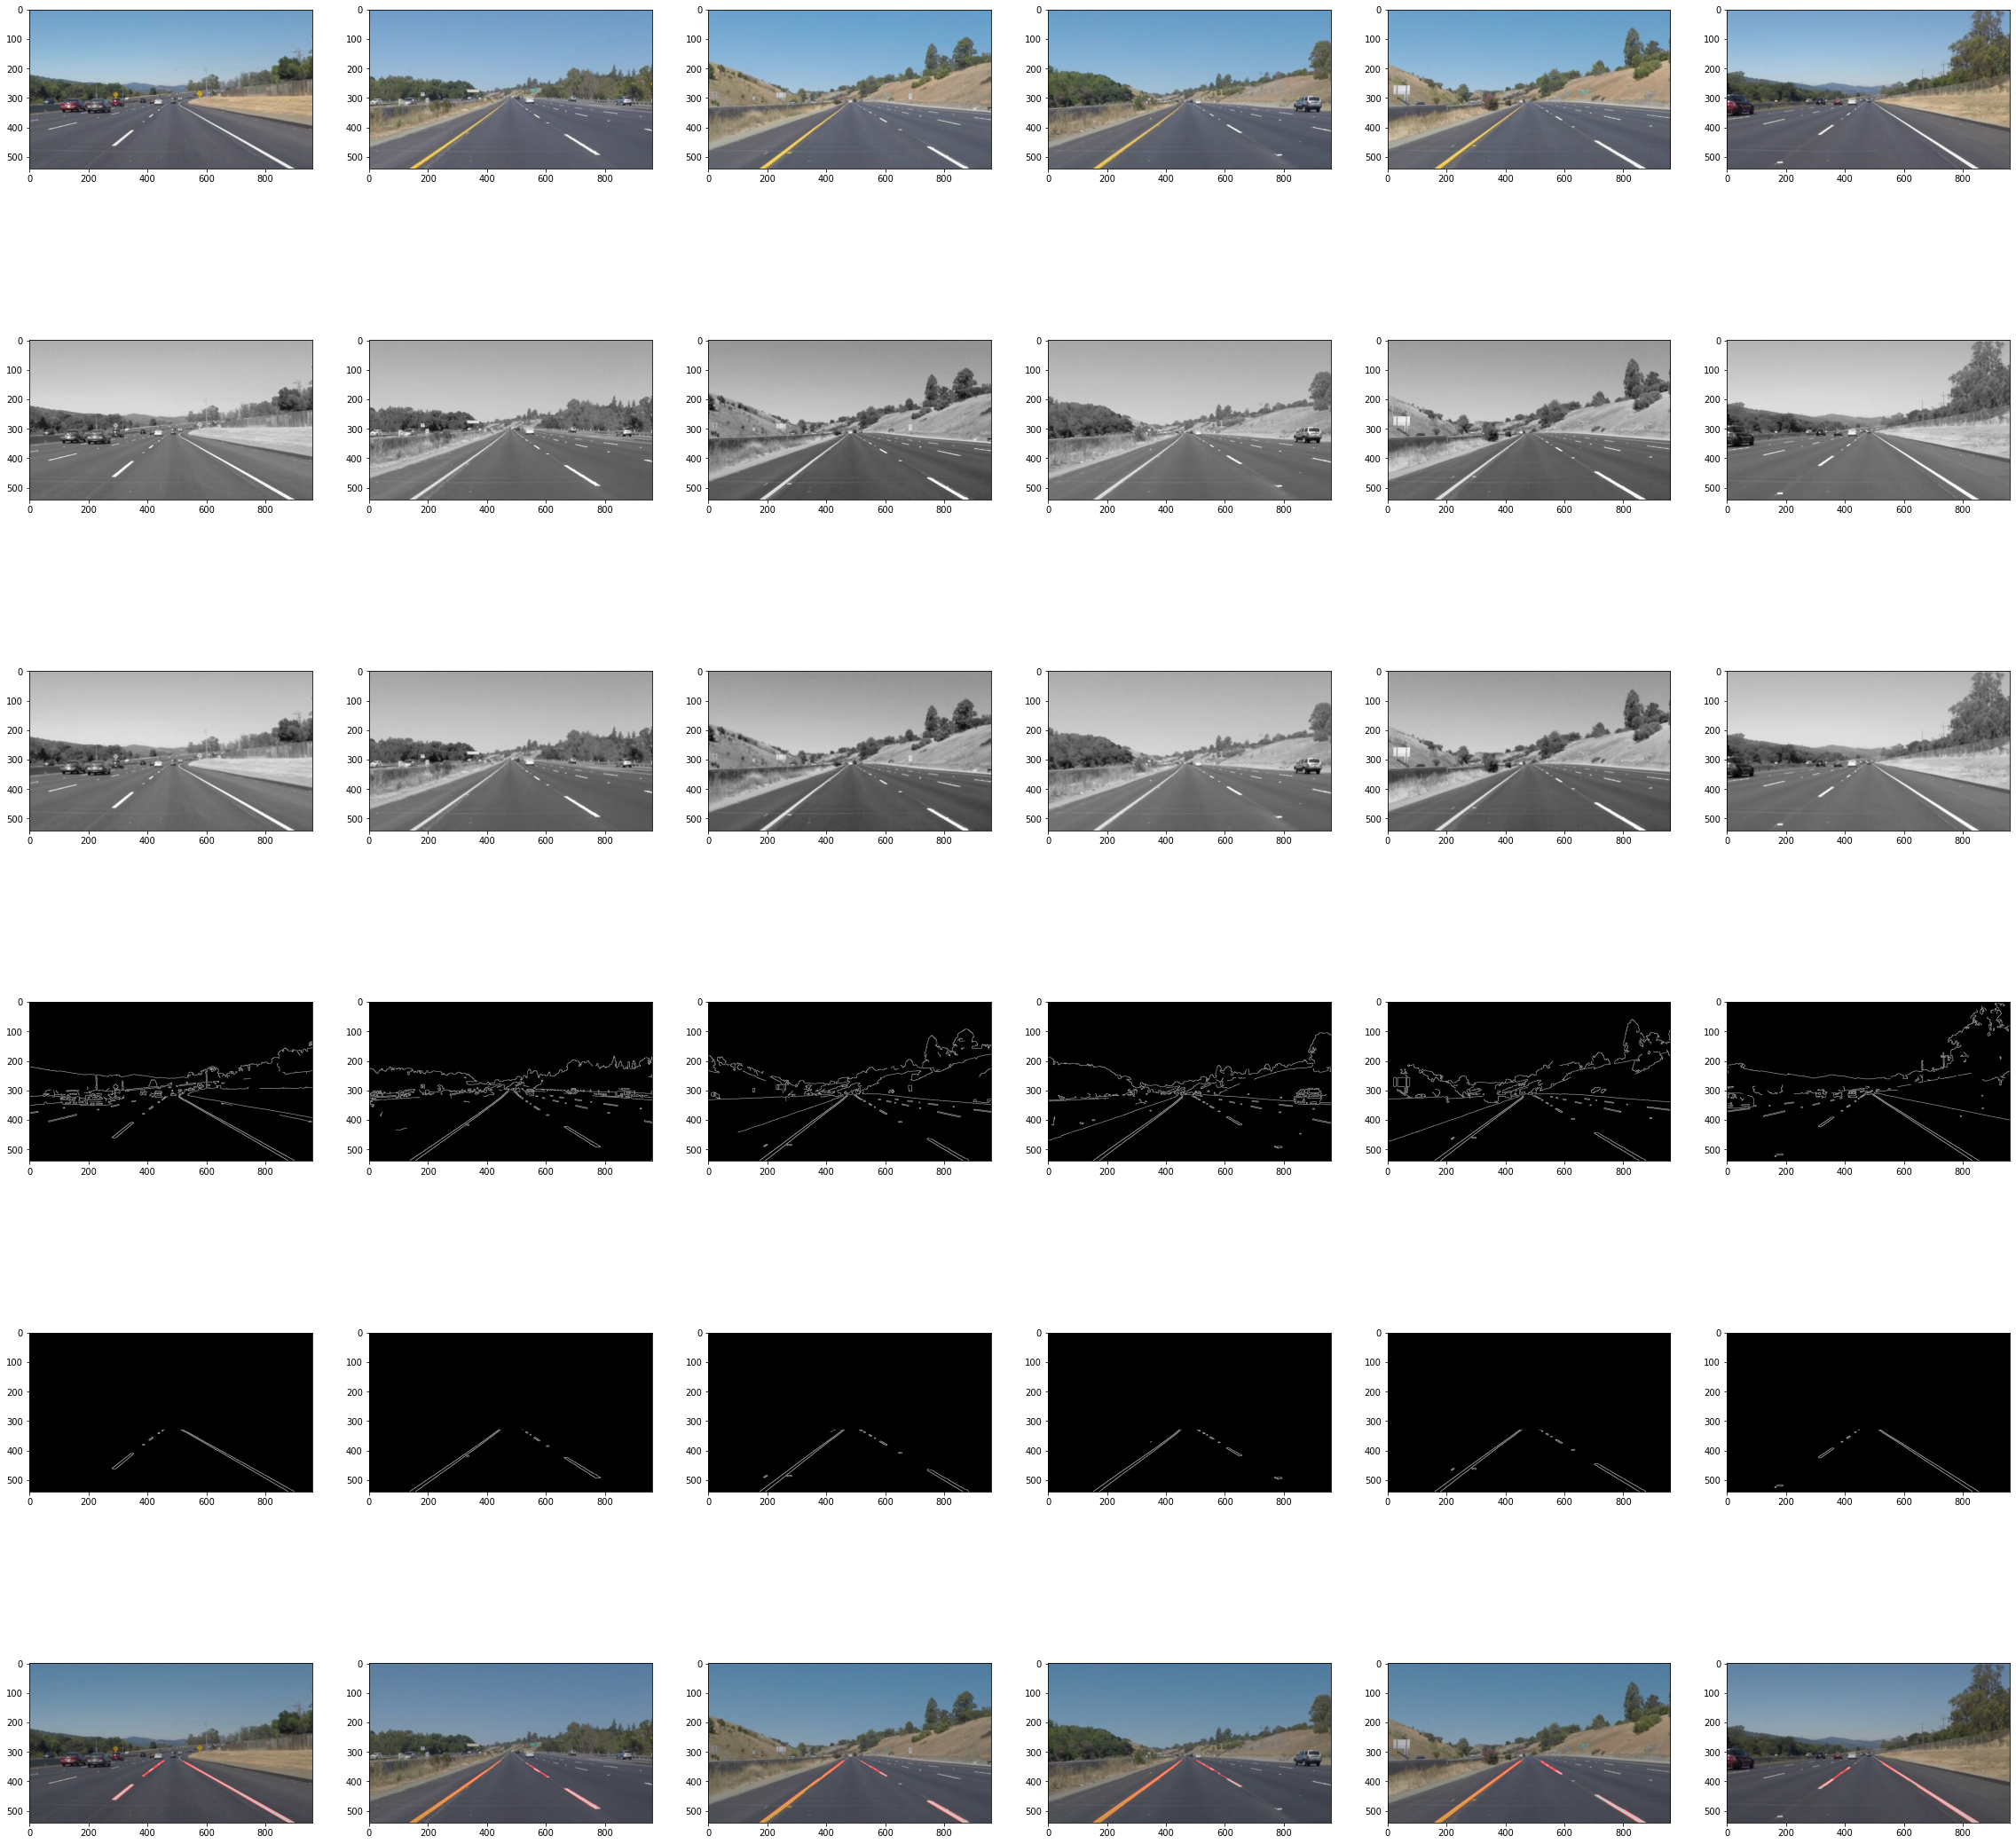

In [5]:
# Test parameters for the given images
lines_added = []
for image_file in images:
    image = mpimg.imread('test_images/{}'.format(image_file))
    lines_added.append(draw_lanes(image))


# Plot the results for the given images
fig, axs = plt.subplots(6, 6)
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i in [1,2,3,4]:
            a.imshow(lines_added[j][i], cmap='Greys_r')
        else:
            a.imshow(lines_added[j][i])
plt.savefig('writeup/fig1.pdf')

## 4. Improving draw_lines

I will now redefine the draw_lines function to fix the issue with the dahsed lane lines not yeilding a clean and extrapolated lane line, and the instability in the solid lane lines.

In [6]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10, vertices=None):
    left_lane = []
    right_lane = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient = (y2 - y1) / (x2 - x1)
            if abs(gradient) > 0.5: # filter out spurious lines due to horizontal road markings
                if gradient >= 0:
                    left_lane.append([x1,y1])
                    left_lane.append([x2,y2])
                else:
                    right_lane.append([x1,y1])
                    right_lane.append([x2,y2])
    left_lane = np.array(left_lane).T
    right_lane = np.array(right_lane).T
    
    try:
        # Now fit a line to each set of points using scipy for the left lane
        f = lambda x, a, b: a*x + b       # y = ax + b
        g = lambda y, a, b: (y - b) / a   # x = (y - b) / a
        a, b = spo.curve_fit(f, left_lane[0,:], left_lane[1,:])[0]

        # Extrapolate in desired region determined by the y values in the vertices and add the line for the left lane
        x1 = g(vertices[0][0][1] - 8, a, b)
        x2 = g(vertices[0][1][1] - 8, a, b)
        y1 = f(x1, a, b)
        y2 = f(x2, a, b)
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
        
    except IndexError:
        pass # No lanes detected, do not draw a line
        
    try:
        # Now fit a line to each set of points using scipy for the right lane
        c, d = spo.curve_fit(f, right_lane[0,:], right_lane[1,:])[0]

        # Extrapolate in desired region determined by the y values in the vertices add the line for the right lane
        x1 = g(vertices[0][0][1] - 8, c, d)
        x2 = g(vertices[0][1][1] - 8, c, d)
        y1 = f(x1, c, d)
        y2 = f(x2, c, d)
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)         
        
    except IndexError:
        pass # No lanes detected, do not draw a line

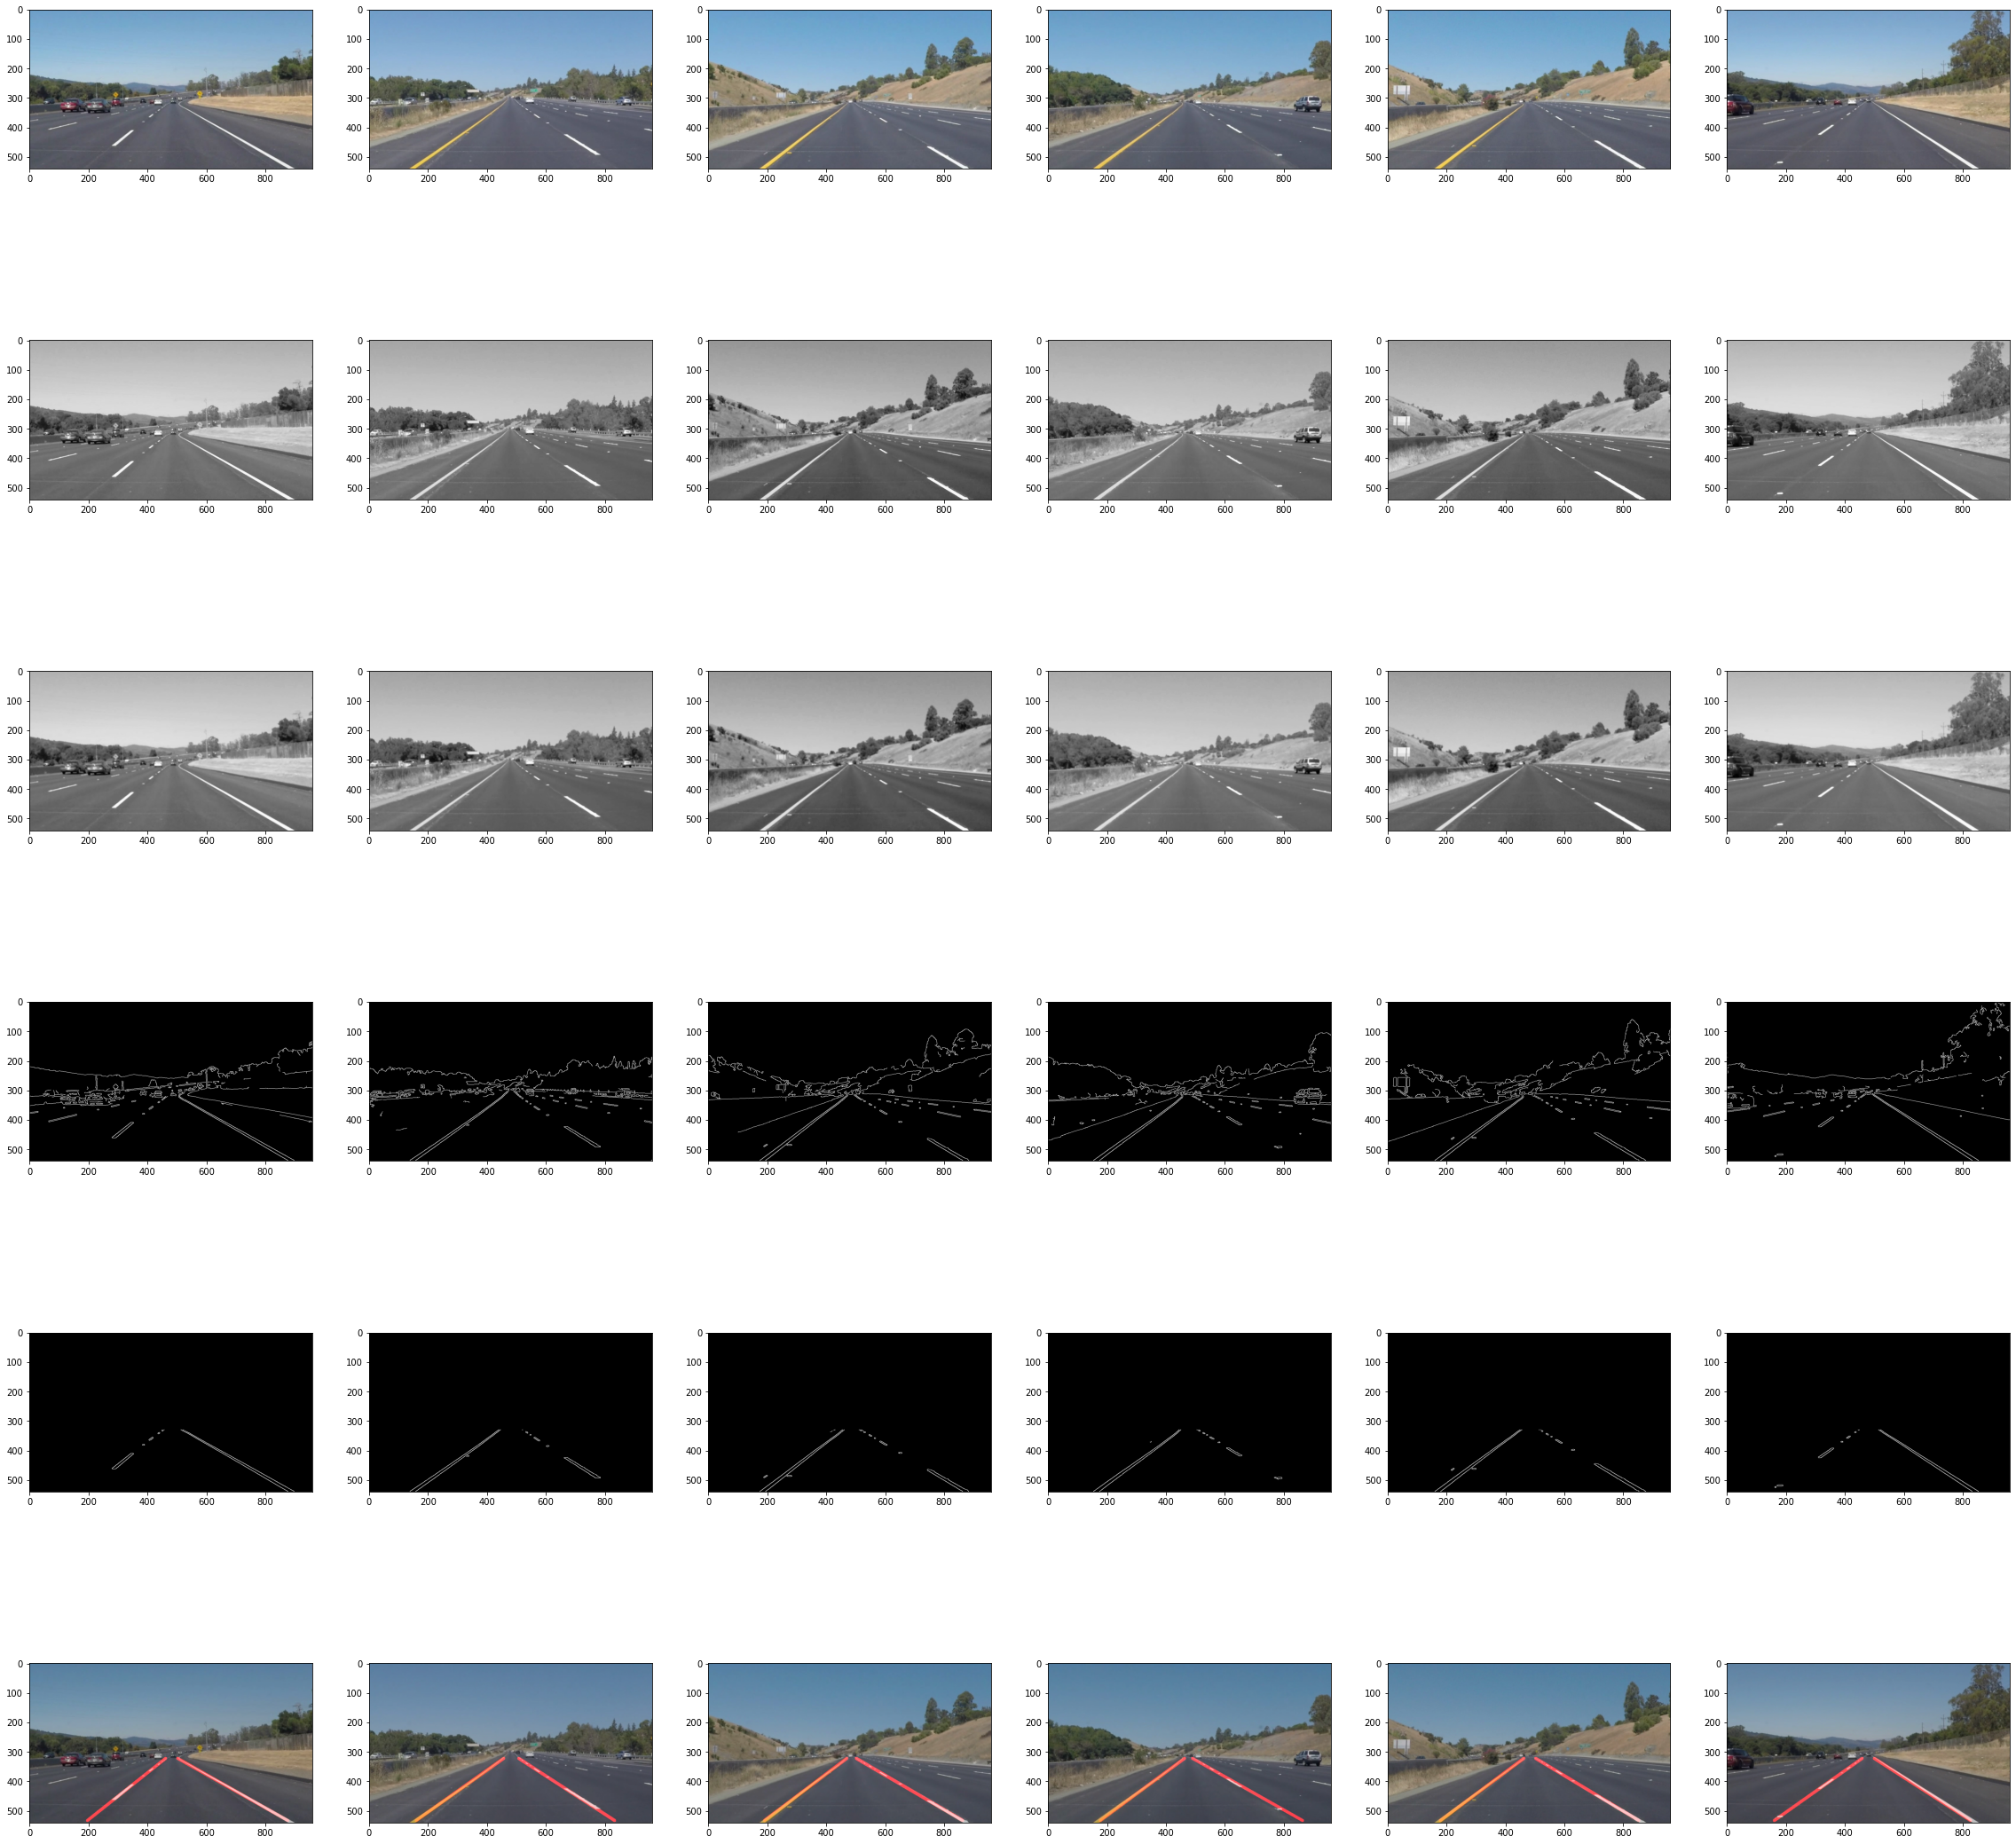

In [7]:
# Test new method for the given images
lines_added = []
for image_file in images:
    image = mpimg.imread('test_images/{}'.format(image_file))
    lines_added.append(draw_lanes(image))


# Plot the results for the given images
fig, axs = plt.subplots(6, 6)
for i, ax in enumerate(axs):
    for j, a in enumerate(ax):
        if i in [1,2,3,4]:
            a.imshow(lines_added[j][i], cmap='Greys_r')
        else:
            a.imshow(lines_added[j][i])
plt.savefig('writeup/fig2.pdf')

## 5. Applying to Videos

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    return draw_lanes(image)[5]

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   7%|▋         | 16/221 [00:00<00:01, 153.82it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 7.93 s, sys: 2.67 s, total: 10.6 s
Wall time: 2.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [12]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 27.1 s, sys: 9.42 s, total: 36.6 s
Wall time: 7.06 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))